# Big Data Lunch full session

## 1. Set dependencies

In [37]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
!rm -rf metastore_db

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL with Hive") \
    .config("spark.sql.warehouse.dir", "/tmp/datalake/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

In [2]:
spark.version

'2.4.4'

## 2. Look around

In [3]:
!ls -lha source/

total 2233696
drwxr-xr-x  10 az255014  365896978   320B Oct 24 11:21 .
drwxr-xr-x  10 az255014  365896978   320B Oct 24 11:25 ..
-rw-r--r--   1 az255014  365896978    23M Oct 24 10:48 customer.tbl
-rw-r--r--   1 az255014  365896978   725M Oct 24 10:48 lineitem.tbl
-rw-r--r--   1 az255014  365896978   2.2K Oct 24 10:48 nation.tbl
-rw-r--r--   1 az255014  365896978   164M Oct 24 10:48 orders.tbl
-rw-r--r--   1 az255014  365896978    23M Oct 24 10:48 part.tbl
-rw-r--r--   1 az255014  365896978   113M Oct 24 10:48 partsupp.tbl
-rw-r--r--   1 az255014  365896978   389B Oct 24 10:48 region.tbl
-rw-r--r--   1 az255014  365896978   1.3M Oct 24 10:48 supplier.tbl


In [4]:
!head source/customer.tbl

1|Customer#000000001|IVhzIApeRb ot,c,E|15|25-989-741-2988|711.56|BUILDING|to the even, regular platelets. regular, ironic epitaphs nag e|
2|Customer#000000002|XSTf4,NCwDVaWNe6tEgvwfmRchLXak|13|23-768-687-3665|121.65|AUTOMOBILE|l accounts. blithely ironic theodolites integrate boldly: caref|
3|Customer#000000003|MG9kdTD2WBHm|1|11-719-748-3364|7498.12|AUTOMOBILE| deposits eat slyly ironic, even instructions. express foxes detect slyly. blithely even accounts abov|
4|Customer#000000004|XxVSJsLAGtn|4|14-128-190-5944|2866.83|MACHINERY| requests. final, regular ideas sleep final accou|
5|Customer#000000005|KvpyuHCplrB84WgAiGV6sYpZq7Tj|3|13-750-942-6364|794.47|HOUSEHOLD|n accounts will have to unwind. foxes cajole accor|
6|Customer#000000006|sKZz0CsnMD7mp4Xd0YrBvx,LREYKUWAh yVn|20|30-114-968-4951|7638.57|AUTOMOBILE|tions. even deposits boost according to the slyly bold packages. final accounts cajole requests. furious|
7|Customer#000000007|TcGe5gaZNgVePxU5kRrvXBfkasDTea|18|28-190-982-9759|956

## 3. Ingestion

In [5]:
!mkdir -p /tmp/datalake/base/customer

In [6]:
!cp source/customer.tbl /tmp/datalake/base/customer/customer_tbl_1

In [8]:
!ls /tmp/datalake/base/customer/

customer_tbl_1


## 4. Inspect Base layer

In [9]:
base_customer = spark.read.csv(path='/tmp/datalake/base/customer/',sep='|')

In [10]:
base_customer.show(5)

+---+------------------+--------------------+---+---------------+-------+----------+--------------------+----+
|_c0|               _c1|                 _c2|_c3|            _c4|    _c5|       _c6|                 _c7| _c8|
+---+------------------+--------------------+---+---------------+-------+----------+--------------------+----+
|  1|Customer#000000001|   IVhzIApeRb ot,c,E| 15|25-989-741-2988| 711.56|  BUILDING|to the even, regu...|null|
|  2|Customer#000000002|XSTf4,NCwDVaWNe6t...| 13|23-768-687-3665| 121.65|AUTOMOBILE|l accounts. blith...|null|
|  3|Customer#000000003|        MG9kdTD2WBHm|  1|11-719-748-3364|7498.12|AUTOMOBILE| deposits eat sly...|null|
|  4|Customer#000000004|         XxVSJsLAGtn|  4|14-128-190-5944|2866.83| MACHINERY| requests. final,...|null|
|  5|Customer#000000005|KvpyuHCplrB84WgAi...|  3|13-750-942-6364| 794.47| HOUSEHOLD|n accounts will h...|null|
+---+------------------+--------------------+---+---------------+-------+----------+--------------------+----+
o

In [11]:
base_customer.schema

StructType(List(StructField(_c0,StringType,true),StructField(_c1,StringType,true),StructField(_c2,StringType,true),StructField(_c3,StringType,true),StructField(_c4,StringType,true),StructField(_c5,StringType,true),StructField(_c6,StringType,true),StructField(_c7,StringType,true),StructField(_c8,StringType,true)))

## 5. Use schema-on-read

In [12]:
r = spark.sql("""create external table if not exists customer (
    C_CUSTKEY INT,
    C_NAME STRING,
    C_ADDRESS STRING,
    C_NATIONKEY INT,
    C_PHONE STRING,
    C_ACCTBAL DOUBLE,
    C_MKTSEGMENT STRING, 
    C_COMMENT STRING
    ) ROW FORMAT DELIMITED FIELDS TERMINATED BY '|'
    STORED AS TEXTFILE LOCATION '/tmp/datalake/base/customer'""")

In [13]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default| customer|      false|
+--------+---------+-----------+



In [14]:
df = spark.sql("select * from customer limit 100")

In [15]:
df.show(5)

+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|C_CUSTKEY|            C_NAME|           C_ADDRESS|C_NATIONKEY|        C_PHONE|C_ACCTBAL|C_MKTSEGMENT|           C_COMMENT|
+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|        1|Customer#000000001|   IVhzIApeRb ot,c,E|         15|25-989-741-2988|   711.56|    BUILDING|to the even, regu...|
|        2|Customer#000000002|XSTf4,NCwDVaWNe6t...|         13|23-768-687-3665|   121.65|  AUTOMOBILE|l accounts. blith...|
|        3|Customer#000000003|        MG9kdTD2WBHm|          1|11-719-748-3364|  7498.12|  AUTOMOBILE| deposits eat sly...|
|        4|Customer#000000004|         XxVSJsLAGtn|          4|14-128-190-5944|  2866.83|   MACHINERY| requests. final,...|
|        5|Customer#000000005|KvpyuHCplrB84WgAi...|          3|13-750-942-6364|   794.47|   HOUSEHOLD|n accounts will h...|
+-------

In [16]:
df.count()

100

In [17]:
df.schema

StructType(List(StructField(C_CUSTKEY,IntegerType,true),StructField(C_NAME,StringType,true),StructField(C_ADDRESS,StringType,true),StructField(C_NATIONKEY,IntegerType,true),StructField(C_PHONE,StringType,true),StructField(C_ACCTBAL,DoubleType,true),StructField(C_MKTSEGMENT,StringType,true),StructField(C_COMMENT,StringType,true)))

In [18]:
df.toPandas().describe()

,C_CUSTKEY,C_NATIONKEY,C_ACCTBAL
count,100.000000,100.000000,100.000000
mean,50.500000,10.980000,4452.531100
std,29.011492,7.105241,3063.820009
min,1.000000,0.000000,-917.750000
25%,25.750000,4.750000,1666.020000
50%,50.500000,10.500000,4608.540000
75%,75.250000,17.000000,6828.147500
max,100.000000,23.000000,9983.380000


## 6. Create curated layer

In [19]:
!mkdir -p /tmp/datalake/curated/

In [20]:
!rm -rf /tmp/datalake/curated/customer

In [21]:
spark.sql("select * from customer").write.parquet("/tmp/datalake/curated/customer")

In [23]:
!du -s -h /tmp/datalake/base/customer
!du -s -h /tmp/datalake/curated/customer

 23M	/tmp/datalake/base/customer
 12M	/tmp/datalake/curated/customer


In [24]:
curated_customer = spark.read.parquet("/tmp/datalake/curated/customer")

In [25]:
curated_customer.show(5)

+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|C_CUSTKEY|            C_NAME|           C_ADDRESS|C_NATIONKEY|        C_PHONE|C_ACCTBAL|C_MKTSEGMENT|           C_COMMENT|
+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|        1|Customer#000000001|   IVhzIApeRb ot,c,E|         15|25-989-741-2988|   711.56|    BUILDING|to the even, regu...|
|        2|Customer#000000002|XSTf4,NCwDVaWNe6t...|         13|23-768-687-3665|   121.65|  AUTOMOBILE|l accounts. blith...|
|        3|Customer#000000003|        MG9kdTD2WBHm|          1|11-719-748-3364|  7498.12|  AUTOMOBILE| deposits eat sly...|
|        4|Customer#000000004|         XxVSJsLAGtn|          4|14-128-190-5944|  2866.83|   MACHINERY| requests. final,...|
|        5|Customer#000000005|KvpyuHCplrB84WgAi...|          3|13-750-942-6364|   794.47|   HOUSEHOLD|n accounts will h...|
+-------

In [26]:
curated_customer.schema

StructType(List(StructField(C_CUSTKEY,IntegerType,true),StructField(C_NAME,StringType,true),StructField(C_ADDRESS,StringType,true),StructField(C_NATIONKEY,IntegerType,true),StructField(C_PHONE,StringType,true),StructField(C_ACCTBAL,DoubleType,true),StructField(C_MKTSEGMENT,StringType,true),StructField(C_COMMENT,StringType,true)))

## 7. Another dataset

In [28]:
!mkdir -p /tmp/datalake/base/orders
!cp source/orders.tbl /tmp/datalake/base/orders/orders_tbl_1

In [29]:
r = spark.sql("""create external table if not exists orders (
    O_ORDERKEY INT,
    O_CUSTKEY INT,
    O_ORDERSTATUS STRING,
    O_TOTALPRICE DOUBLE,
    O_ORDERDATE STRING,
    O_ORDERPRIORITY STRING,
    O_CLERK STRING,
    O_SHIPPRIORITY INT,
    O_COMMENT STRING
    ) ROW FORMAT DELIMITED FIELDS TERMINATED BY '|'
    STORED AS TEXTFILE LOCATION '/tmp/datalake/base/orders'""")

In [30]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default| customer|      false|
| default|   orders|      false|
+--------+---------+-----------+



In [31]:
customer_distribution = spark.sql("""
select 
  c_count, count(1) as custdist
from 
  (select 
     c_custkey, count(o_orderkey) as c_count
   from 
     customer c left outer join orders o 
     on 
       c.c_custkey = o.o_custkey and not o.o_comment like '%special%requests%'
   group by c_custkey
   ) c_orders
group by c_count
order by custdist desc, c_count desc
""")

In [32]:
customer_distribution.show(5)

+-------+--------+
|c_count|custdist|
+-------+--------+
|      0|   50005|
|      9|    6641|
|     10|    6532|
|     11|    6014|
|      8|    5937|
+-------+--------+
only showing top 5 rows



In [34]:
!mkdir /tmp/datalake/product/

mkdir: /tmp/datalake/product/: File exists


In [35]:
customer_distribution.write.parquet('/tmp/datalake/product/customer_distribution')

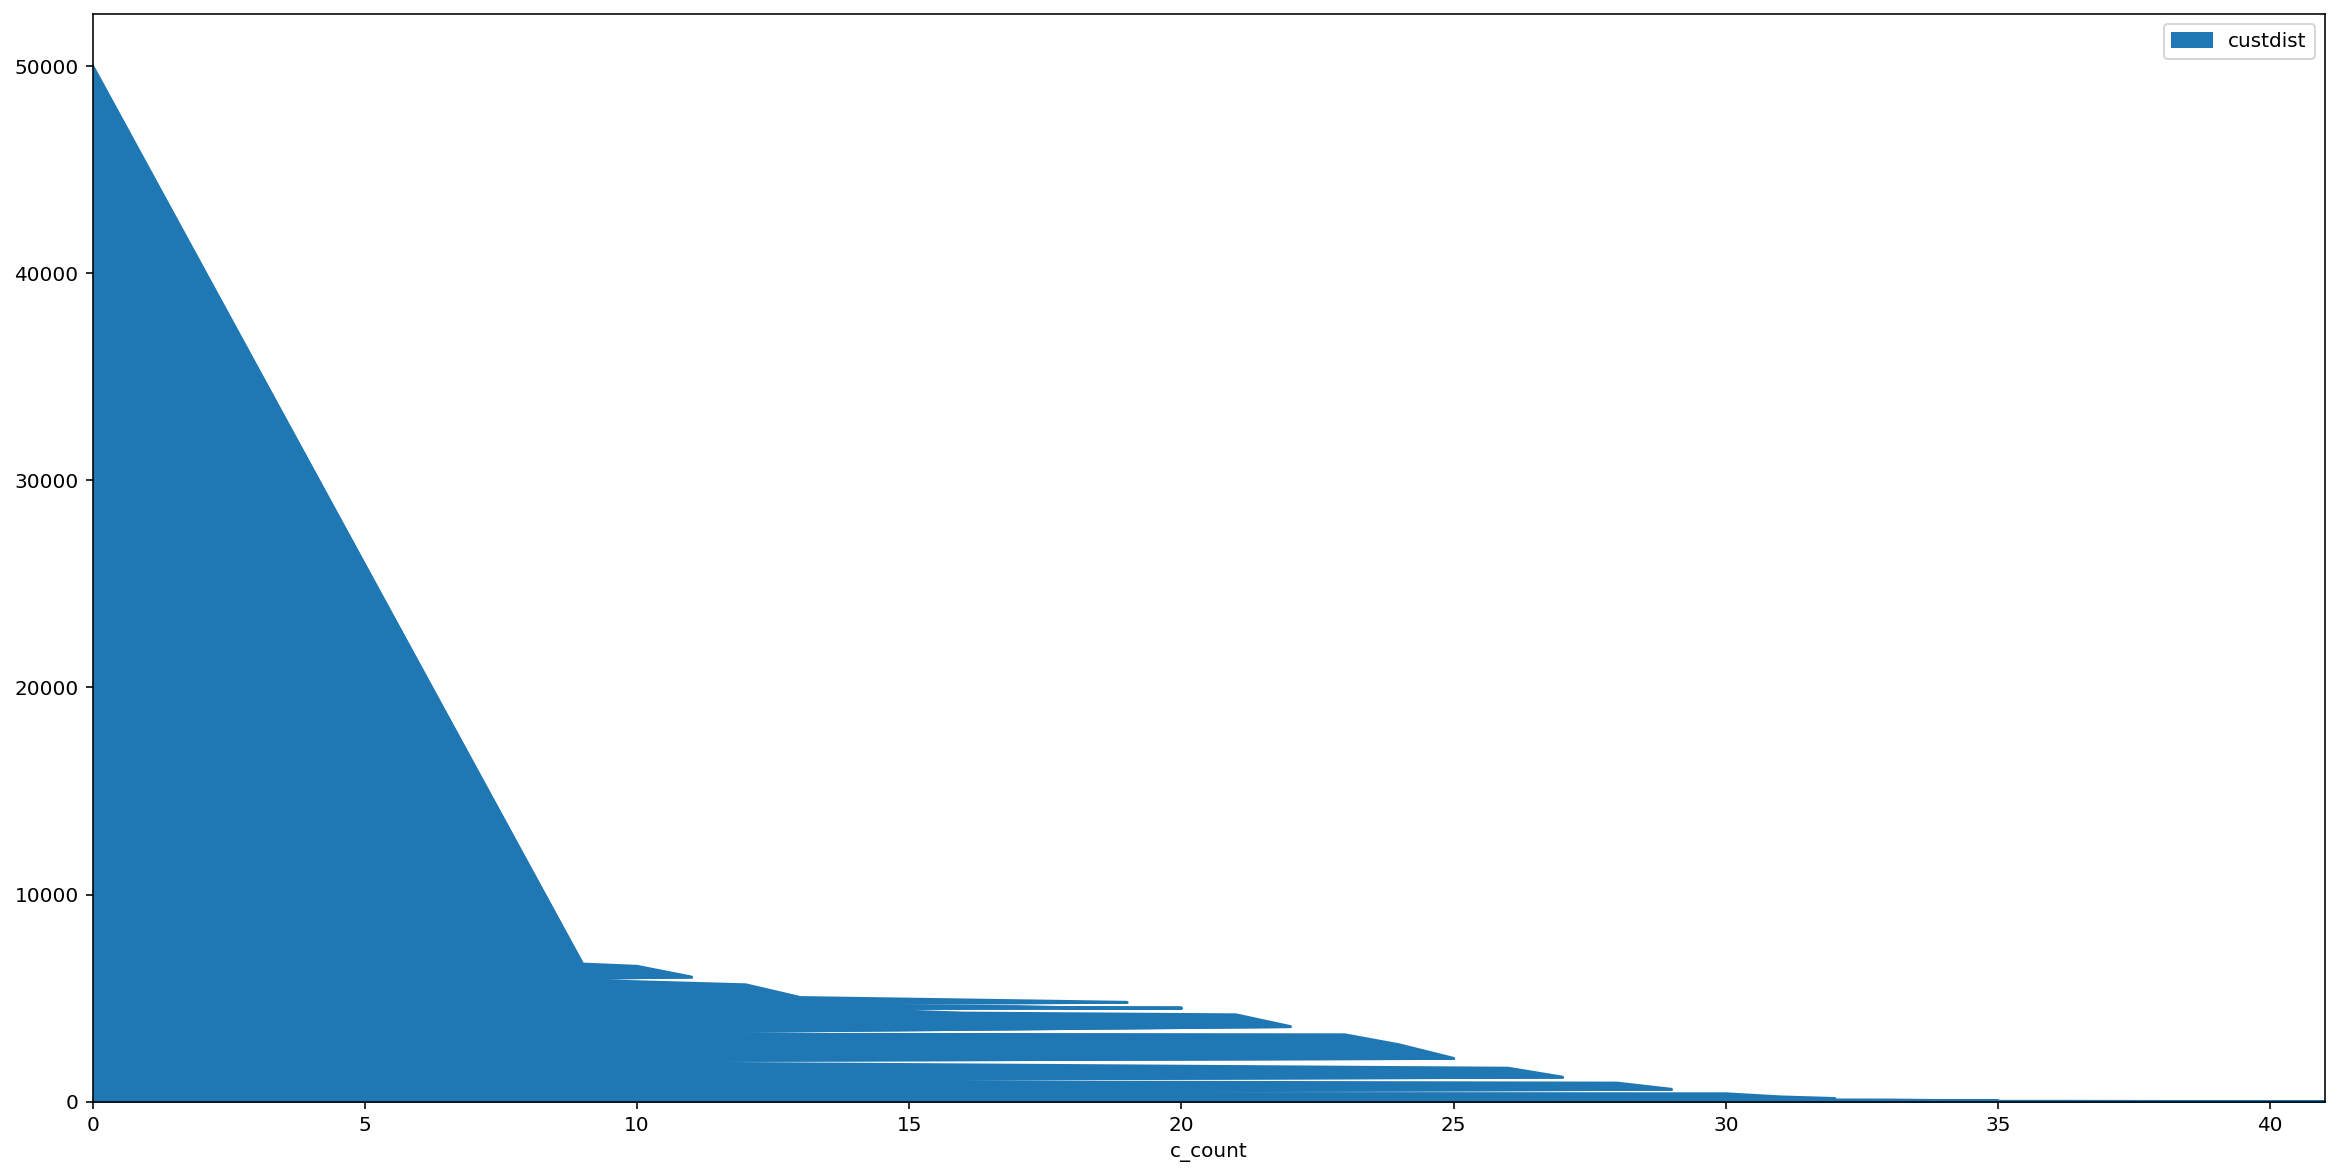

In [38]:
customer_distribution.toPandas().plot(x = 'c_count', y = 'custdist', kind = 'area')